In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# rainforest classifier
from sklearn.ensemble import RandomForestClassifier

# linear regession classifier
from sklearn.linear_model import LogisticRegression

import wrangle as w


In [2]:
# # acquiring, cleaning, and adding features to data
df = w.get_telco_data()
# df = w.prep_telco()

In [3]:
df

,payment_type_id,internet_service_type_id,customer_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,churn_month,signup_date,internet_service_type,payment_type
0,2,1,0002-ORFBO,2,Female,0,Yes,Yes,9,Yes,...,No,Yes,65.60,593.3,No,One year,None,2021-04-21 18:07:34,DSL,Mailed check
1,2,1,0003-MKNFE,1,Male,0,No,No,9,Yes,...,Yes,No,59.90,542.4,No,Month-to-month,None,2021-04-21 18:07:34,DSL,Mailed check
2,1,2,0004-TLHLJ,1,Male,0,No,No,4,Yes,...,No,Yes,73.90,280.85,Yes,Month-to-month,2022-01-31,2021-09-21 18:07:34,Fiber optic,Electronic check
3,1,2,0011-IGKFF,1,Male,1,Yes,No,13,Yes,...,Yes,Yes,98.00,1237.85,Yes,Month-to-month,2022-01-31,2020-12-21 18:07:34,Fiber optic,Electronic check
4,2,2,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,...,No,Yes,83.90,267.4,Yes,Month-to-month,2022-01-31,2021-10-21 18:07:34,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,1,9987-LUTYD,2,Female,0,No,No,13,Yes,...,No,No,55.15,742.9,No,One year,None,2020-12-21 18:07:34,DSL,Mailed check
7039,1,2,9992-RRAMN,1,Male,0,Yes,No,22,Yes,...,Yes,Yes,85.10,1873.7,Yes,Month-to-month,2022-01-31,2020-03-21 18:07:34,Fiber optic,Electronic check
7040,2,1,9992-UJOEL,1,Male,0,No,No,2,Yes,...,No,Yes,50.30,92.75,No,Month-to-month,None,2021-11-21 18:07:34,DSL,Mailed check
7041,2,1,9993-LHIEB,3,Male,0,Yes,Yes,67,Yes,...,Yes,No,67.85,4627.65,No,Two year,None,2016-06-21 18:07:34,DSL,Mailed check


# Summarize df 

In [6]:
# Get information about df, such as column names, rows, datatypes, non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   payment_type_id           7043 non-null   int64         
 1   internet_service_type_id  7043 non-null   int64         
 2   customer_id               7043 non-null   object        
 3   contract_type_id          7043 non-null   int64         
 4   gender                    7043 non-null   object        
 5   senior_citizen            7043 non-null   int64         
 6   partner                   7043 non-null   object        
 7   dependents                7043 non-null   object        
 8   tenure                    7043 non-null   int64         
 9   phone_service             7043 non-null   object        
 10  multiple_lines            7043 non-null   object        
 11  online_security           7043 non-null   object        
 12  online_backup       

In [7]:
# Get summary statistics for numeric columns.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [8]:
# Use .describe with object columns.

obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')


0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
0002-ORFBO    0.000142
6616-AALSR    0.000142
6625-UTXEW    0.000142
6625-IUTTT    0.000142
6625-FLENO    0.000142
                ...   
3352-RICWQ    0.000142
3352-ALMCK    0.000142
3351-NQLDI    0.000142
3351-NGXYI    0.000142
9995-HOTOH    0.000142
Name: customer_id, Length: 7043, dtype: float64
----------------------
Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
----------------------
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
----------------------
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
----------------------
Yes    6361
No      682
Nam

In [9]:
# Find columns with nulls and the total of missing values.
missing = df.isnull().sum()
missing[missing > 0]

churn_month    5174
dtype: int64

# Clean the Data

In [4]:
# Drop duplicates, reassign and check the shape of df. *No change to df shape
df = df.drop_duplicates()
df.shape

(7043, 26)

In [5]:
df = w.prep_telco_2()
df

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,churn,payment_type,payment_encoded,partner_Yes,dependents_Yes,paperless_billing_Yes,churn_Yes
0,0002-ORFBO,0,Yes,Yes,9,Yes,Yes,65.60,593.30,No,Mailed check,0,1,1,1,0
1,0003-MKNFE,0,No,No,9,Yes,No,59.90,542.40,No,Mailed check,0,0,0,0,0
2,0004-TLHLJ,0,No,No,4,Yes,Yes,73.90,280.85,Yes,Electronic check,0,0,0,1,1
3,0011-IGKFF,1,Yes,No,13,Yes,Yes,98.00,1237.85,Yes,Electronic check,0,1,0,1,1
4,0013-EXCHZ,1,Yes,No,3,Yes,Yes,83.90,267.40,Yes,Mailed check,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,0,No,No,13,Yes,No,55.15,742.90,No,Mailed check,0,0,0,0,0
7039,9992-RRAMN,0,Yes,No,22,Yes,Yes,85.10,1873.70,Yes,Electronic check,0,1,0,1,1
7040,9992-UJOEL,0,No,No,2,Yes,Yes,50.30,92.75,No,Mailed check,0,0,0,1,0
7041,9993-LHIEB,0,Yes,Yes,67,Yes,No,67.85,4627.65,No,Mailed check,0,1,1,0,0


In [32]:
# encoding payment type automatic payment equals 1 and non_automatic equals 0
df["payment_encoded"] = df.payment_type.map({"Bank transfer (automatic)": 1, "Credit card (automatic)": 1, "Mailed check": 0, "Electronic check": 0})

In [36]:
df.payment_encoded.value_counts()

0    3977
1    3066
Name: payment_encoded, dtype: int64

In [37]:
df.payment_type.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64

In [17]:
df1 = df[["partner_Yes", "dependents_Yes", "paperless_billing_Yes", "payment_encoded", "churn_Yes"]]

In [18]:
df1

,partner_Yes,dependents_Yes,paperless_billing_Yes,payment_encoded,churn_Yes
0,1,1,1,0,0
1,0,0,0,0,0
2,0,0,1,0,1
3,1,0,1,0,1
4,1,0,1,0,1
...,...,...,...,...,...
7038,0,0,0,0,0
7039,1,0,1,0,1
7040,0,0,1,0,0
7041,1,1,0,0,0


In [19]:
# cleaning column names for easier recall and because it's formal
df1 = df1.rename(columns={"partner_Yes": "partner", "dependents_Yes": "dependents", "paperless_billing_Yes": "paperless_billing", "payment_encoded": "automatic_payment", "churn_Yes": "churn" })

# Split data 

In [52]:
target = "churn"

In [26]:
train, validate, test = w.split_data(df1,target)

In [29]:
# Validate split.
def valid_split(train, validate, test):
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')

In [30]:
valid_split(train, validate, test)

train -> (4225, 5)
validate -> (1409, 5)
test -> (1409, 5)


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 5911 to 3586
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   partner            4225 non-null   uint8
 1   dependents         4225 non-null   uint8
 2   paperless_billing  4225 non-null   uint8
 3   automatic_payment  4225 non-null   int64
 4   churn              4225 non-null   uint8
dtypes: int64(1), uint8(4)
memory usage: 82.5 KB


In [33]:
train.head()

,partner,dependents,paperless_billing,automatic_payment,churn
5911,0,1,1,1,0
2479,1,0,0,0,0
5889,0,0,1,0,1
6087,0,0,1,1,0
785,0,0,0,1,0


# QUESTION 1: Do customers that have an automatic payment type more or less likely to churn?

* What's the relationship between churn and payment type?

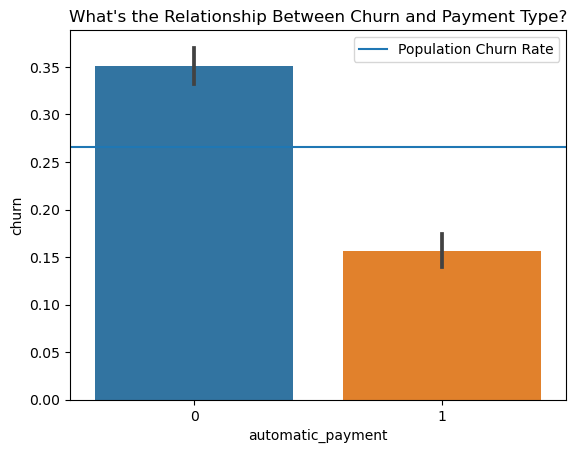

In [36]:
plt.title("What's the Relationship Between Churn and Automatic Payment Type?")
sns.barplot(x="automatic_payment", y="churn", data=train)
population_churn_rate = train.churn.mean()
plt.axhline(population_churn_rate, label="Population Churn Rate")
plt.legend()
plt.show()

In [61]:
# Setup a crosstab of observed survival to pclass
def cross_function(train, target_variable, feature_variable, null_hypothesis, alternative_hypothesis):
    '''
    This function will take the train df, target_variable, and feature_variable
    '''
    observed = pd.crosstab(train[target_variable], train[feature_variable])

    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        print(f"Reject the null hypothesis: {null_hypothesis}")
        print(f"Sufficient evidence to move forward understanding that, {alternative_hypothesis}")
    else:
        print("Fail to reject the null")
        print("Insufficient evidence to reject the null")
    return p

In [63]:
# Chi squared to compare proportions, define confidence
alpha_Q1 = 0.05
target_Q1 = "churn"
feature_variable_Q1 = "automatic_payment"
null_hypothesis_Q1 = "churn and automatic payment are independent"
alternative_hypothesis_Q1 = "there is a relationship between automatic payment and churn"

cross_function(train, target, feature_variable_Q1, null_hypothesis_Q1, alternative_hypothesis_Q1)

Reject the null hypothesis: churn and automatic payment are independent
Sufficient evidence to move forward understanding that, there is a relationship between automatic payment and churn


1.2588150001387785e-45

# Question 2:  Do customers that have paperless billing more or less likely to churn?
* What's the relationship between churn and paperless billing?

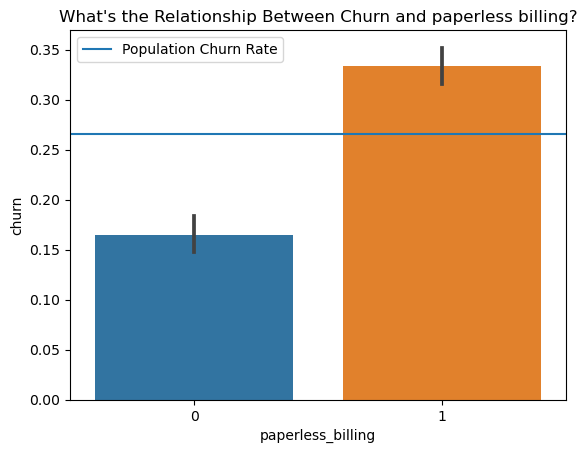

In [47]:
plt.title("What's the Relationship Between Churn and paperless billing?")
sns.barplot(x="paperless_billing", y="churn", data=train)
population_churn_rate = train.churn.mean()
plt.axhline(population_churn_rate, label="Population Churn Rate")
plt.legend()
plt.show()

In [64]:
# Chi squared to compare proportions, define confidence
alpha_Q2 = 0.05
target_Q2 = "churn"
feature_variable_Q2 = "paperless_billing"
null_hypothesis_Q2 = "churn and paperless_billing are independent"
alternative_hypothesis_Q2 = "there is a relationship between paperless_billing and churn"

cross_function(train, target, feature_variable_Q2, null_hypothesis_Q2, alternative_hypothesis_Q2)

Reject the null hypothesis: churn and paperless_billing are independent
Sufficient evidence to move forward understanding that, there is a relationship between paperless_billing and churn


3.5348504574964642e-34

# Question 3: Do customers that have partner more or less likely to churn?
* What's the relationship between churn and customers' with partners?

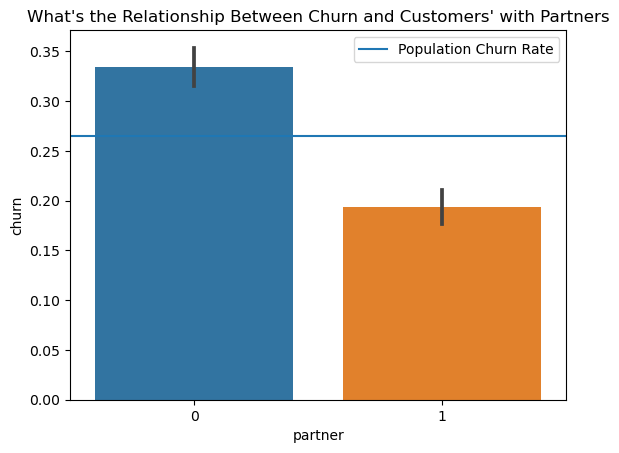

In [65]:
plt.title("What's the Relationship Between Churn and Customers' with Partners")
sns.barplot(x="partner", y="churn", data=train)
population_churn_rate = train.churn.mean()
plt.axhline(population_churn_rate, label="Population Churn Rate")
plt.legend()
plt.show()

In [66]:
# Chi squared to compare proportions, define confidence
alpha_Q3 = 0.05
target_Q3 = "churn"
feature_variable_Q3 = "partner"
null_hypothesis_Q3 = "churn and customers' with partners are independent"
alternative_hypothesis_Q3 = "there is a relationship between customers' with partners and churn"

cross_function(train, target, feature_variable_Q3, null_hypothesis_Q3, alternative_hypothesis_Q3)

Reject the null hypothesis: churn and customers' with partners are independent
Sufficient evidence to move forward understanding that, there is a relationship between customers' with partners and churn


5.362120825511991e-25

# Question 4: Do customers that have dependents more or less likely to churn?
* What's the relationship between churn and customers' with dependents?

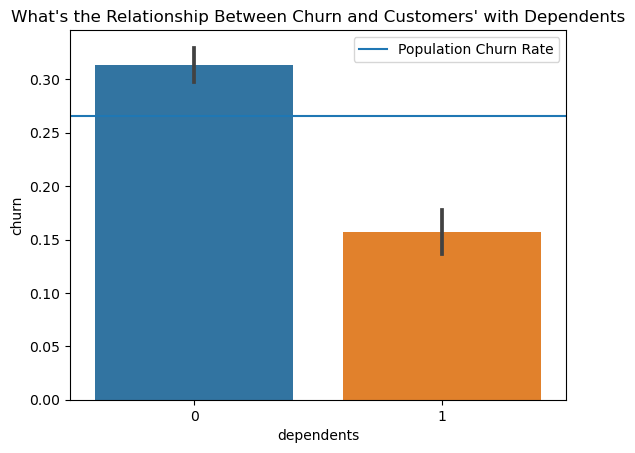

In [46]:
plt.title("What's the Relationship Between Churn and Customers' with Dependents")
sns.barplot(x="dependents", y="churn", data=train)
population_churn_rate = train.churn.mean()
plt.axhline(population_churn_rate, label="Population Churn Rate")
plt.legend()
plt.show()

In [67]:
alpha_Q4 = 0.05
target_Q4 = "churn"
feature_variable_Q4 = "dependents"
null_hypothesis_Q4 = "churn and customers' with dependents are independent"
alternative_hypothesis_Q4 = "there is a relationship between customers' with dependents and churn"

cross_function(train, target, feature_variable_Q4, null_hypothesis_Q4, alternative_hypothesis_Q4)

Reject the null hypothesis: churn and customers' with dependents are independent
Sufficient evidence to move forward understanding that, there is a relationship between customers' with dependents and churn


4.0728740930257527e-26

* positive class:  not churned
* negative class:  churned

# Decision Tree Model  

In [158]:
def create_x_y(train, validate, test, target):
    """
    This function creates x and y variables for either a decision tree or a random forest, 
    by using the unsplit df, target variable columns name and column to drop, for multiple columns that need to be 
    dropped create a list of the columns0
    The arguments taken in are train, validate, test, target, drop_col=[])
    The function returns x_train, y_train, x_validate, y_validate, x_test, y_test
    """
    # separates train target variable
    x_train = train.drop(columns=[target])
    y_train = train[target]
    # validate 
    x_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    # test
    x_test = test.drop(columns=[target])
    y_test = test[target]
    
    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [175]:
# creating baseline:  1's = churned & 0's = not churned  baseline accuracy = 0.7346745562130178
# positive if not churned
baseline_accuracy = (train.churn == 0).mean()
baseline_accuracy


0.7346745562130178

In [163]:
# using a function to get x & y variables for the split dataset
x_train, y_train, x_validate, y_validate, x_test, y_test = create_x_y(train, validate, test, target)

In [173]:
# create object 
tree = DecisionTreeClassifier(random_state=3)

# model.fit(x, y)
tree = tree.fit(x_train, y_train)

# score for train = 0.7401183431952663 --- this is greater than the baseline
train_accuracy = tree.score(x_train, y_train)

# score for validate = 0.7196593328601846 --- this is less than the baseline
validate_accuracy = tree.score(x_validate, y_validate)
validate_accuracy

0.7196593328601846

In [172]:
# make prediction on train obeservations
y_pred = tree.predict(x_train)

#estimate probablility 
y_pred_proba = tree.predict_proba(x_train)

In [124]:
# create confusion matrix
conf = confusion_matrix(y_train, y_pred)

# nice dataframe with conf
labels = sorted(y_train.unique())
pd.DataFrame(conf,
            index=[str(label) + '_actual'for label in labels],
            columns=[str(label) + '_predict'for label in labels])

,0_predict,1_predict
0_actual,2724,380
1_actual,718,403


In [137]:
TP, FP, FN, TN = conf.ravel()
TP

2724

In [139]:
# check accuracy 
accuracy_score(y_train, y_pred)

0.7401183431952663

# Random Forest model

In [177]:
# create object
rf = RandomForestClassifier(random_state=3)

# fit model
rf.fit(x_train, y_train)

# evaluate feature importance
print(rf.feature_importances_)

[0.11720507 0.15751509 0.31153932 0.41374053]


In [178]:
# create prdictions
y_pred_rf = rf.predict(x_train)

# Estimate the probability
y_pred_proba_rf = rf.predict_proba(x_train)


In [184]:
# create confusion matrix
conf_rf = confusion_matrix(y_train, y_pred_rf)

# nice dataframe with conf
labels = sorted(y_train.unique())
pd.DataFrame(conf_rf,
            index=[str(label) + '_actual'for label in labels],
            columns=[str(label) + '_predict'for label in labels])


,0_predict,1_predict
0_actual,2724,380
1_actual,718,403


In [186]:
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3104
           1       0.51      0.36      0.42      1121

    accuracy                           0.74      4225
   macro avg       0.65      0.62      0.63      4225
weighted avg       0.72      0.74      0.72      4225



In [211]:
# evaluate model 
# rf train accuracy score = 0.7401183431952663
rf.score(x_train, y_train)

# rf  validate accuracy score = 0.7196593328601846
rf.score(x_validate, y_validate)

0.7196593328601846

# Linear Regression Model

In [189]:
# create object
logit = LogisticRegression()

# model fit 
logit.fit(x_train, y_train)

LogisticRegression()

In [190]:
# evaluate importance of each feature
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


Coefficient: 
 [[-0.42184525 -0.55147039  0.90267313 -0.98603615]]
Intercept: 
 [-0.90162982]


In [213]:
# make predictions
y_pred_lr = logit.predict(x_train)
y_pred_proba_lr = logit.predict_proba(x_train)
# compute accuracy
print(f'''
    Accuracy of Logistic Regression classifier on training set: {round(logit.score(x_train, y_train),2)}
    Accuracy of Logistic Regression classifier on validation set: {round(logit.score(x_validate, y_validate),2)}
''')

print(confusion_matrix(y_train, y_pred_lr))



    Accuracy of Logistic Regression classifier on training set: 0.74
    Accuracy of Logistic Regression classifier on validation set: 0.72

[[2724  380]
 [ 718  403]]


In [229]:
# classification report
print(classification_report(y_train, y_pred_lr))
y_pred_proba_lr

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      3104
           1       0.51      0.36      0.42      1121

    accuracy                           0.74      4225
   macro avg       0.65      0.62      0.63      4225
weighted avg       0.72      0.74      0.72      4225



array([[0.82294999, 0.17705001],
       [0.78975929, 0.21024071],
       [0.49973917, 0.50026083],
       ...,
       [0.49973917, 0.50026083],
       [0.71128432, 0.28871568],
       [0.71128432, 0.28871568]])

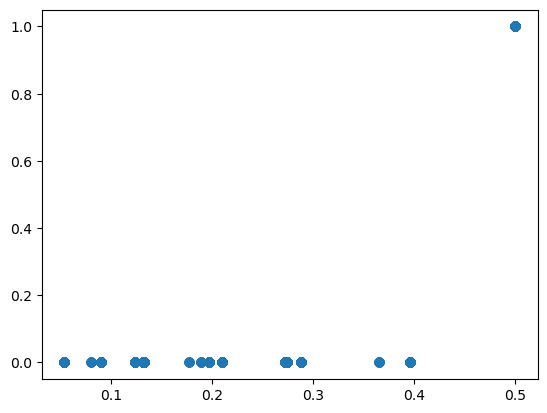

<Figure size 1000x600 with 0 Axes>

In [228]:
# Visualize #################################
# create array of probabilities of churning

y_pred_proba_churn = np.array([i[1] for i in y_pred_proba_lr])

fig = plt.figure()
plt.figure(figsize=(10,6))
ax = fig.add_subplot()


# scatter plot where x is the probabilities and y is the churn (0, 1)
ax.scatter(y_pred_proba_churn, y_pred_lr)


In [226]:
y_pred_proba_churn[y_pred_proba_churn > 0.5]

array([0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026083,
       0.50026083, 0.50026083, 0.50026083, 0.50026083, 0.50026

In [230]:
# Test Model
print(f'''
    Accuracy of Logistic Regression classifier on training set: {round(logit.score(x_train, y_train),2)}
    Accuracy of Logistic Regression classifier on validation set: {round(logit.score(x_validate, y_validate),2)}
    Accuracy of Logistic Regression classifier on test set: {round(logit.score(x_test, y_test),2)}
    
''')


    Accuracy of Logistic Regression classifier on training set: 0.74
    Accuracy of Logistic Regression classifier on validation set: 0.72
    Accuracy of Logistic Regression classifier on test set: 0.74

